In [1]:
import numpy as np
from math import pi
import cmath
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt

In [2]:
nH = 1e-9
pF = 1e-12
MHz = 1e6

In [3]:
L = 12*nH
C = 6*pF
Z0 = 50 #Ohms
N = 5
Cc = np.arange(1, N)*0.08*pF
Qi = 1e5
f = np.linspace(570, 590, 100000)*MHz
w = 2*pi*f
R = 5e5 #Ohms

In [4]:
Ct = C + Cc
w0 = 1/(L*Ct)**0.5
Qis = w0*R*C
frs = (w0*(1-1/4/Qis**2)**0.5)/2/pi/MHz
# print (Qi)
# print(frs)
Qcs = (2*C)/(Z0*2*pi*frs*MHz*Cc**2)
Qrs = 1/(1/Qcs + 1/Qis)

In [5]:
def I(theta, f):
    f0, Qcd, Qrd = theta
    x = (f-f0)/f0
    return 1 - (Qcd*Qrd)/(Qrd**2 + 4*x**2)

def Q(theta, f):
    f0, Qcd, Qrd = theta
    x = (f-f0)/f0
    return (2*x*Qcd)/(Qrd**2 + 4*x**2)

def S21_fit(theta, f):
    f0, Qcd, Qrd = theta
    x = (f-f0)/f0
    return 1 - Qcd/(Qrd + 1j*2*x)
        
def chisq(theta, f, y):
    return 0.5*np.sum((y.real - I(theta, f))**2) + 0.5*np.sum((y.imag - Q(theta, f))**2)

def get_Qparams(f, S21):
    Qi = 5e4
    x0 = [f[np.argmin(S21.real)], 1/Qi, 2/Qi] 
    result = opt.minimize(chisq, x0, args=(f, S21), method='Nelder-Mead')
    f0, Qcd, Qrd = result["x"]
    return f0, 1/Qcd, 1/Qrd

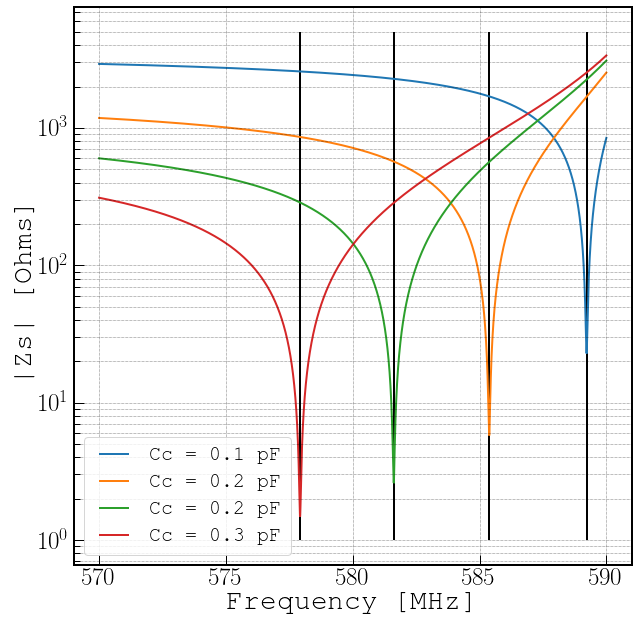

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr + 1/(1j*w*Cc[i])
    S21 = (2*Zs)/(2*Zs + Z0)
    ax.semilogy(f/MHz, np.abs(Zs), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(frs[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
# ax.set_ylim([-25000, 25000])
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zs| [Ohms]');

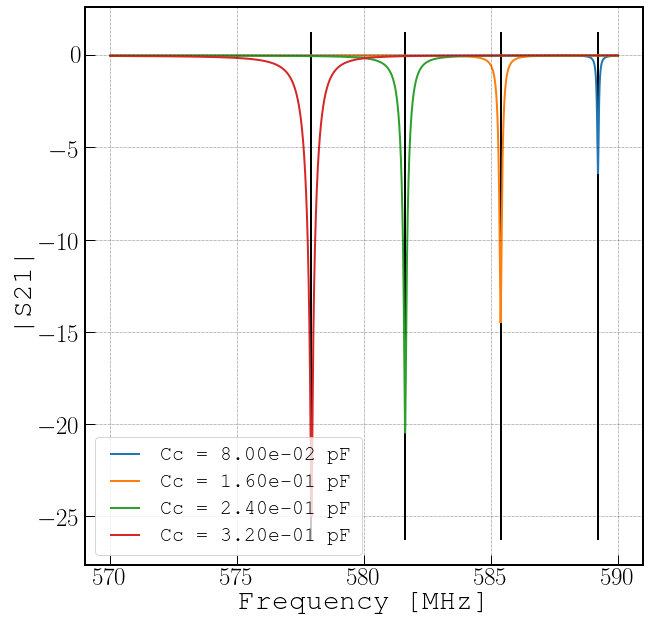

In [7]:
Qr_fitted = np.zeros(N-1)
Qi_fitted = np.zeros(N-1)
Qc_fitted = np.zeros(N-1)
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr + 1/(1j*w*Cc[i])
    S21 = (2*Zs)/(2*Zs + Z0)
    f0, Qc, Qr = get_Qparams(f, S21)
    Qi = 1/(1/Qr - 1/Qc)
#     print (frs[i], f0/MHz)
#     print (Qr, Qc, Qi)
    Qr_fitted[i] = Qr
    Qi_fitted[i] = Qi
    Qc_fitted[i] = Qc
    ax.plot(f/MHz, 20*np.log10(np.abs(S21)), label="Cc = {0:1.2e} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(frs[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|S21|');

In [8]:
print ("%r"%Qcs)
print("%r"%Qc_fitted)
print ("\n")
print ("%r"%Qis)
print ("%r"%Qi_fitted)
print ("\n")
print ("%r"%Qrs)
print ("%r"%Qr_fitted)

array([10129.16581994,  2548.89682281,  1140.17542628,   645.44679361])
array([9963.27076582, 2581.75481856, 1180.40513128,  685.81777421])


array([11106.54145798, 11034.18536881, 10963.22524134, 10893.61675826])
array([10918.40559724, 11160.00121102, 11295.93767336, 11430.15359756])


array([5297.68086561, 2070.59043243, 1032.76759617,  609.34320847])
array([5209.49704444, 2096.70342274, 1068.72526678,  646.99744318])


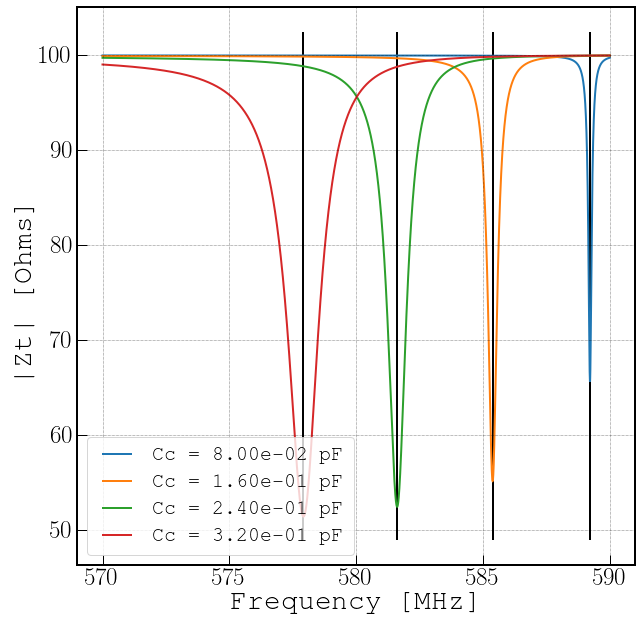

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr + 1/(1j*w*Cc[i])
    Zt = Z0 * (2*Zs + Z0)/(Zs + Z0)
    ax.plot(f/MHz, np.abs(Zt), label="Cc = {0:1.2e} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(frs[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
# ax.set_ylim([50, 200])
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zt| [Ohms]');

Now let's consider the double resonator case

In [10]:
Lm = 30*nH
we = 1/(L*C)**0.5
Qe = we*R*Ct
Lp = L*(Lm/2)/(L + Lm/2)
wo = 1/(Lp*C)**0.5
Qo = wo*R*Ct
fm = we*(1-L/(4*R**2*C))**0.5/2/pi/MHz
fp = wo*(1-Lp/(4*R**2*C))**0.5/2/pi/MHz
# frs_even = (we)/2/pi/MHz
# frs_odd = (wo)/2/pi/MHz
print (fm, fp)

593.1354522545121 795.7747150173795


In [11]:
w_even = 1/(L*Ct)**0.5
frs_even = w_even*(1-1/4/Qe**2)**0.5/2/pi/MHz
w_odd = 1/(Lp*Ct)**0.5
frs_odd = w_odd*(1-1/4/Qo**2)**0.5/2/pi/MHz
print (frs_even)
print (frs_odd)

[589.22032399 585.38171426 581.61716259 577.92431789]
[790.52201924 785.37198385 780.32130778 775.3668367 ]


In [12]:
fr_evens = []
fr_odds = []
for i in range(N-1):
    # Discriminant of a quartic polynomial
    a = C*(C + Cc[i])*L**2*Lm*R**2
    b = (2*C + Cc[i])*L**2*Lm*R
    c = L*(L*Lm + (2*C + Cc[i])*(L + Lm)*R**2)
    d = 2*L*(L + Lm)*R
    e = (2*L + Lm)*R**2
    x1,x2,x3,x4 = np.roots([a,b,c,d,e])
    fr_odds.append(np.abs(np.imag(x1))/2/pi/MHz)
    fr_evens.append(np.abs(np.imag(x3))/2/pi/MHz)
print (fr_evens)
print (fr_odds)

[591.1519631813103, 589.1566079422851, 587.1506921285562, 585.1355063747648]
[793.1744536130024, 790.6759604245075, 788.2750339815747, 785.9676166148545]


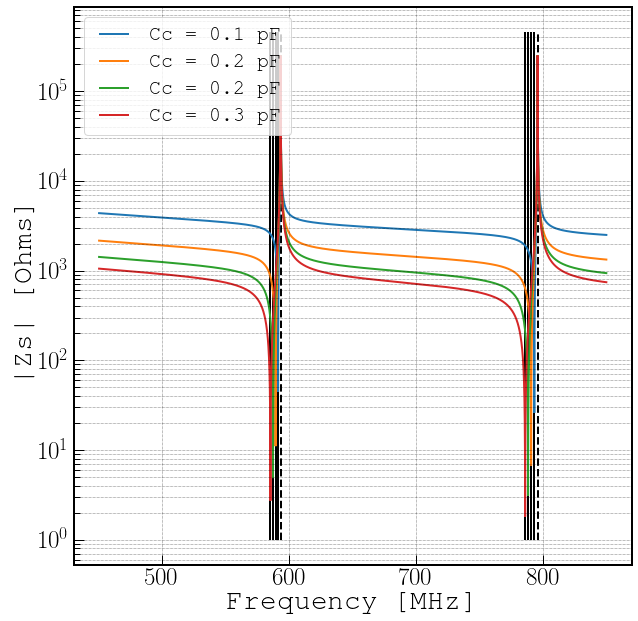

In [13]:
f = np.linspace(450, 850, 100000)*MHz
w = 2*pi*f
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr * (Zr + 1j*w*Lm)/(2*Zr + 1j*w*Lm)  + 1/(1j*w*Cc[i])
    S21 = (2*Zs)/(2*Zs + Z0)
    ax.semilogy(f/MHz, np.abs(Zs), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(fr_evens[i], ymin, ymax, 'k')
    ax.vlines(fr_odds[i], ymin, ymax, 'k')
ax.vlines(fm, ymin, ymax, 'k', linestyles='dashed')
ax.vlines(fp, ymin, ymax, 'k', linestyles='dashed')

ax.legend(loc='upper left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zs| [Ohms]');

In [14]:
Qc_lower = np.zeros(N-1)
Qc_upper = np.zeros(N-1)
Qi_lower = np.zeros(N-1)
Qi_upper = np.zeros(N-1)
Qr_lower = np.zeros(N-1)
Qr_upper = np.zeros(N-1)
f0_lower = np.zeros(N-1)
f0_upper = np.zeros(N-1)

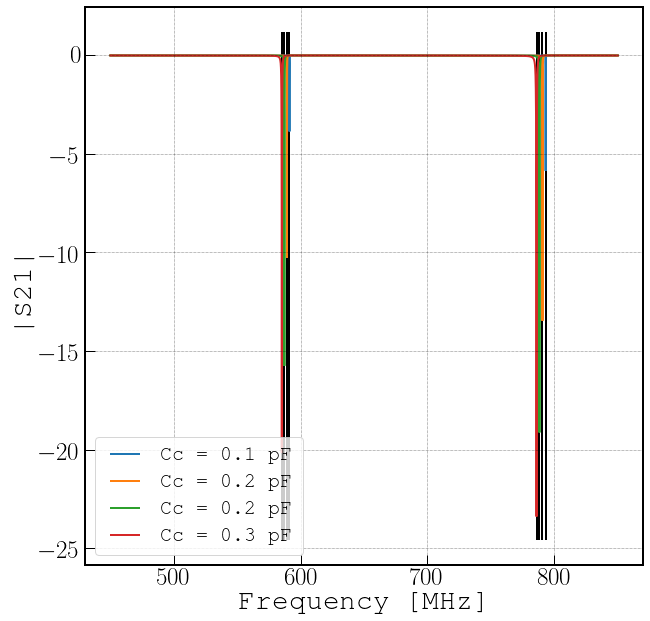

In [16]:
T = len(f)
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr * (Zr + 1j*w*Lm)/(2*Zr + 1j*w*Lm)  + 1/(1j*w*Cc[i])
 
    S21 = (2*Zs)/(2*Zs + Z0)
    ax.plot(f/MHz, 20*np.log10(np.abs(S21)), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
    f0_l, Qc_l, Qr_l = get_Qparams(f[:T//2], S21[:T//2])
    f0_u, Qc_u, Qr_u = get_Qparams(f[T//2:], S21[T//2:])
    Qi_l = 1/(1/Qr_l - 1/Qc_l)
    Qi_u = 1/(1/Qr_u - 1/Qc_u)
    f0_lower[i] = f0_l
    f0_upper[i] = f0_u
    Qc_lower[i] = Qc_l
    Qc_upper[i] = Qc_u
    Qi_lower[i] = Qi_l
    Qi_upper[i] = Qi_u
    Qr_lower[i] = Qr_l
    Qr_upper[i] = Qr_u
#     ax.plot(f/MHz, 20*np.log10(np.abs(S21_est)), ls='dashed', label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(fr_evens[i], ymin, ymax, 'k')
    ax.vlines(fr_odds[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|S21|');

In [31]:
type(Lm)

float

In [40]:
alpha = np.power((2*pi*f0_lower)**2*Lm*Cc - 1, -2)
print (Qc_lower/Qc_upper)
print (frs_odd/frs_even)

[1.28276676 1.22719302 1.1743236  1.12421166]
[1.34164079 1.34164079 1.34164079 1.34164079]


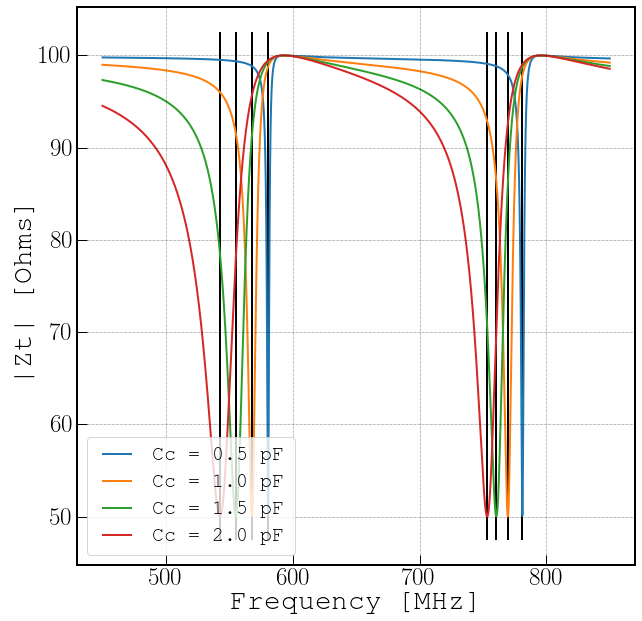

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(N-1):
    Zr = (1j*w*R*L)/(1j*w*L + R*(1 - w**2*L*C)) 
    Zs = Zr * (Zr + 1j*w*Lm)/(2*Zr + 1j*w*Lm)  + 1/(1j*w*Cc[i])
    Zt = Z0*(2*Zs + Z0)/(Zs + Z0)
    ax.plot(f/MHz, np.abs(Zt), label="Cc = {0:3.1f} pF".format(Cc[i]/pF))
ymin, ymax = ax.get_ylim()
for i in range(N-1):
    ax.vlines(fr_evens[i], ymin, ymax, 'k')
    ax.vlines(fr_odds[i], ymin, ymax, 'k')
ax.legend(loc='lower left')
ax.grid(which='both')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('|Zt| [Ohms]');